In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [ ]:
# The following code was referenced from this tutorial: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("picasso.jpg")
content_img = image_loader("dancing.jpg")


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


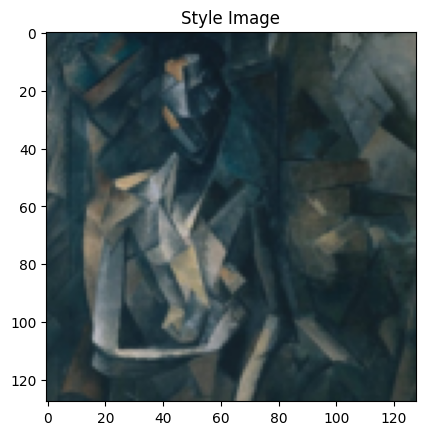

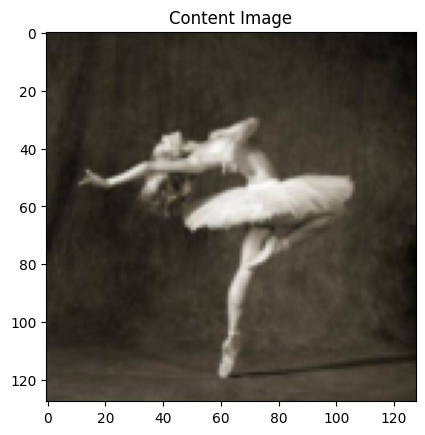

In [ ]:
# The following code was referenced from this tutorial: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
# The following code was referenced from this tutorial: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return self.loss

In [ ]:
# The following code was referenced from this tutorial: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
# The following code was referenced from this tutorial: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return self.loss

In [ ]:
# The following code was referenced from this tutorial: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
normalization_mean = torch.tensor([0.485, 0.456, 0.406])
normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


tensor(0.0071, grad_fn=<MseLossBackward0>) tensor(0.2922, grad_fn=<MseLossBackward0>)


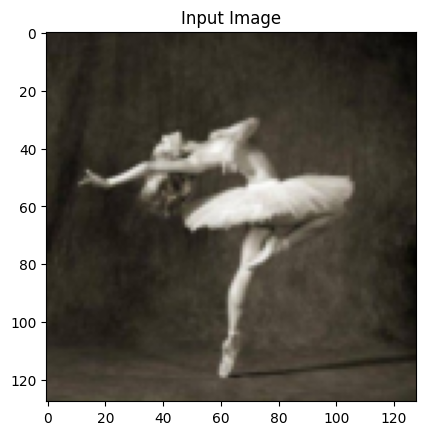

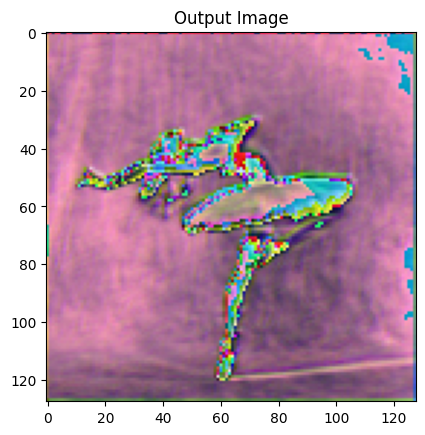

In [ ]:
class CNN1(nn.Module):
    def __init__(self, style_img, content_img):
        super(CNN1, self).__init__()
        self.style_img = style_img
        self.content_img = content_img
        self.normalization = Normalization(normalization_mean, normalization_std)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.style_loss = StyleLoss(style_img)
        self.content_loss = ContentLoss(content_img)


    def forward(self, x):
        # normalize ``img``
        h = self.normalization(x)
        h = self.conv1(h)
        #h = self.BN1(h)
        sloss = self.style_loss(h)
        closs = self.content_loss(h)
        return h, sloss, closs

model = CNN1(style_img, content_img)
out, sloss, closs = model.forward(content_img)

print(sloss, closs)

plt.figure()
imshow(content_img, title='Input Image')

plt.figure()
imshow(out, title='Output Image')

tensor(0.0379, grad_fn=<MseLossBackward0>) tensor(0.7553, grad_fn=<MseLossBackward0>)


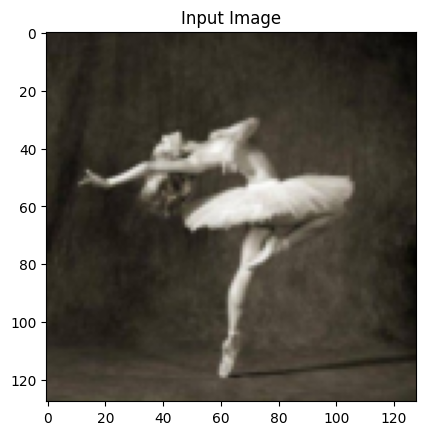

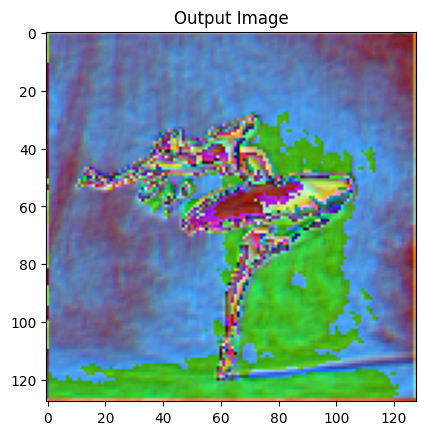

In [ ]:
class CNN1_BN(nn.Module):
    def __init__(self, style_img, content_img):
        super(CNN1_BN, self).__init__()
        self.style_img = style_img
        self.content_img = content_img
        self.normalization = Normalization(normalization_mean, normalization_std)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.style_loss = StyleLoss(style_img)
        self.content_loss = ContentLoss(content_img)


    def forward(self, x):
        # normalize ``img``
        h = self.normalization(x)
        h = self.conv1(h)
        h = self.BN1(h)
        sloss = self.style_loss(h)
        closs = self.content_loss(h)
        return h, sloss, closs

model = CNN1(style_img, content_img)
out, sloss, closs = model.forward(content_img)

print(sloss, closs)

plt.figure()
imshow(content_img, title='Input Image')

plt.figure()
imshow(out, title='Output Image')

tensor(0.0130, grad_fn=<AddBackward0>) tensor(0.6454, grad_fn=<AddBackward0>)


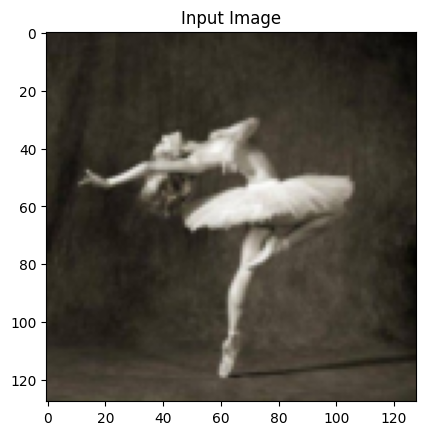

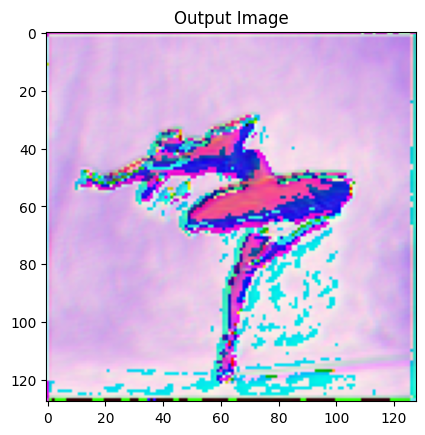

In [ ]:
class CNN2(nn.Module):
    def __init__(self, style_img, content_img):
        super(CNN2, self).__init__()
        self.style_img = style_img
        self.content_img = content_img
        self.normalization = Normalization(normalization_mean, normalization_std)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU()

        self.style_loss = StyleLoss(style_img)
        self.content_loss = ContentLoss(content_img)


    def forward(self, x):
        # normalize ``img``
        h = self.normalization(x)
        h = self.conv1(h)
        sloss = self.style_loss(h)
        closs = self.content_loss(h)
        #h = self.BN1(h)
        h = self.relu1(h)

        h = self.conv2(h)
        closs += self.content_loss(h)
        sloss += self.style_loss(h)
        #h = self.BN2(h)
        return h, sloss, closs

model = CNN2(style_img, content_img)
out, sloss, closs = model.forward(content_img)

print(sloss, closs)

plt.figure()
imshow(content_img, title='Input Image')

plt.figure()
imshow(out, title='Output Image')

tensor(0.0086, grad_fn=<AddBackward0>) tensor(0.7338, grad_fn=<AddBackward0>)


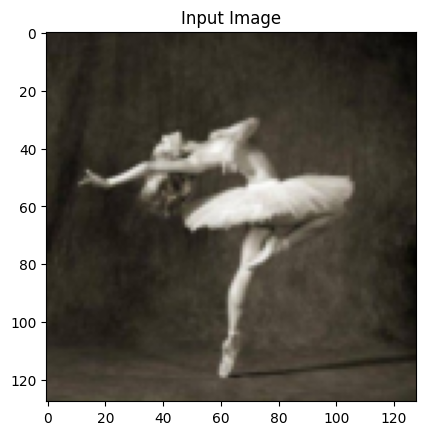

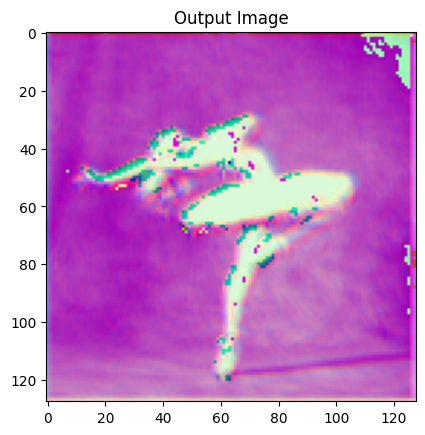

In [ ]:
class CNN2_BN(nn.Module):
    def __init__(self, style_img, content_img):
        super(CNN2_BN, self).__init__()
        self.style_img = style_img
        self.content_img = content_img
        self.normalization = Normalization(normalization_mean, normalization_std)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU()

        self.style_loss = StyleLoss(style_img)
        self.content_loss = ContentLoss(content_img)


    def forward(self, x):
        # normalize ``img``
        h = self.normalization(x)
        h = self.conv1(h)
        sloss = self.style_loss(h)
        closs = self.content_loss(h)
        h = self.BN1(h)
        h = self.relu1(h)

        h = self.conv2(h)
        closs += self.content_loss(h)
        sloss += self.style_loss(h)
        #h = self.BN2(h)
        return h, sloss, closs

model = CNN2(style_img, content_img)
out, sloss, closs = model.forward(content_img)

print(sloss, closs)

plt.figure()
imshow(content_img, title='Input Image')

plt.figure()
imshow(out, title='Output Image')

tensor(0.0273, grad_fn=<AddBackward0>) tensor(0.9016, grad_fn=<AddBackward0>)


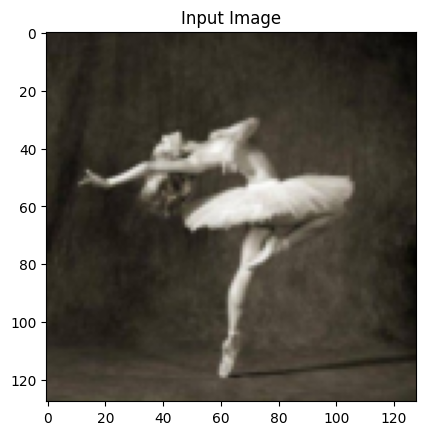

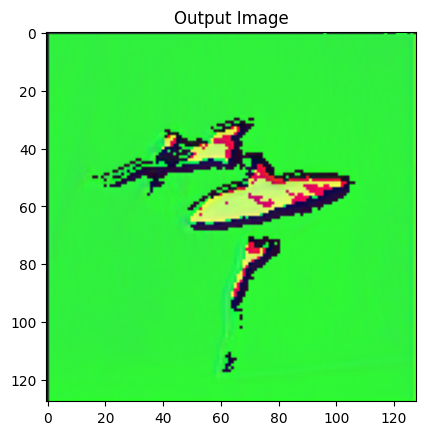

In [ ]:
class CNN3(nn.Module):
    def __init__(self, style_img, content_img):
        super(CNN3, self).__init__()
        self.style_img = style_img
        self.content_img = content_img
        self.normalization = Normalization(normalization_mean, normalization_std)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN3 = nn.BatchNorm2d(3)
        self.relu3 = nn.ReLU()

        self.style_loss = StyleLoss(style_img)
        self.content_loss = ContentLoss(content_img)


    def forward(self, x):
        # normalize ``img``
        h = self.normalization(x)
        h = self.conv1(h)
        sloss = self.style_loss(h)
        closs = self.content_loss(h)
        #h = self.BN1(h)
        h = self.relu1(h)

        h = self.conv2(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN1(h)
        h = self.relu2(h)

        h = self.conv3(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN1(h)

        return h, sloss, closs

model = CNN3(style_img, content_img)
out, sloss, closs = model.forward(content_img)

print(sloss, closs)

plt.figure()
imshow(content_img, title='Input Image')

plt.figure()
imshow(out, title='Output Image')

tensor(0.0486, grad_fn=<AddBackward0>) tensor(1.1950, grad_fn=<AddBackward0>)


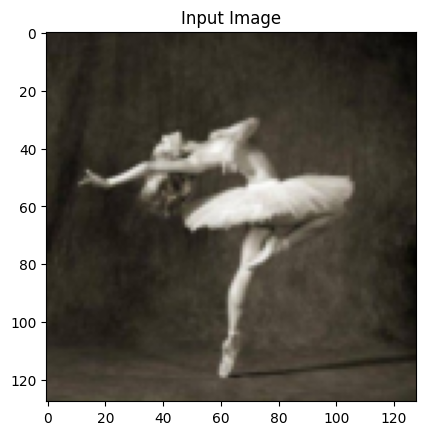

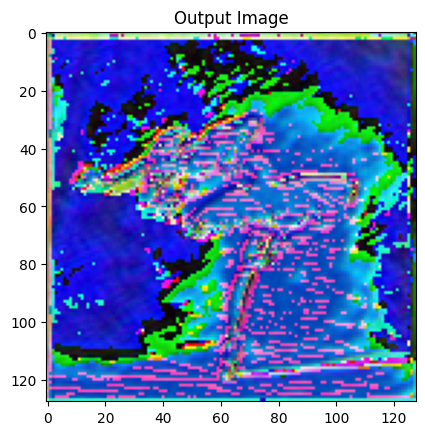

In [ ]:
class CNN3_BN(nn.Module):
    def __init__(self, style_img, content_img):
        super(CNN3_BN, self).__init__()
        self.style_img = style_img
        self.content_img = content_img
        self.normalization = Normalization(normalization_mean, normalization_std)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN3 = nn.BatchNorm2d(3)
        self.relu3 = nn.ReLU()

        self.style_loss = StyleLoss(style_img)
        self.content_loss = ContentLoss(content_img)


    def forward(self, x):
        # normalize ``img``
        h = self.normalization(x)
        h = self.conv1(h)
        sloss = self.style_loss(h)
        closs = self.content_loss(h)
        h = self.BN1(h)
        h = self.relu1(h)

        h = self.conv2(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        h = self.BN2(h)
        h = self.relu2(h)

        h = self.conv3(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN1(h)

        return h, sloss, closs

model = CNN3_BN(style_img, content_img)
out, sloss, closs = model.forward(content_img)

print(sloss, closs)

plt.figure()
imshow(content_img, title='Input Image')

plt.figure()
imshow(out, title='Output Image')

tensor(0.2391, grad_fn=<AddBackward0>) tensor(2.3878, grad_fn=<AddBackward0>)


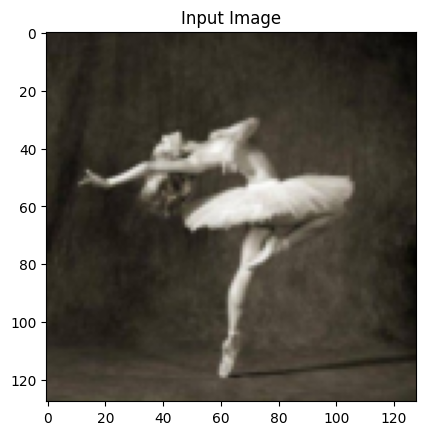

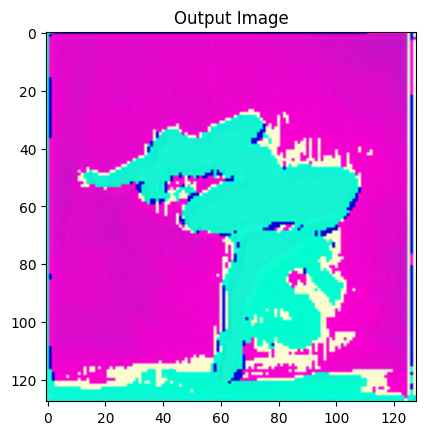

In [ ]:
class CNN4(nn.Module):
    def __init__(self, style_img, content_img):
        super(CNN4, self).__init__()
        self.style_img = style_img
        self.content_img = content_img
        self.normalization = Normalization(normalization_mean, normalization_std)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN3 = nn.BatchNorm2d(3)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN4 = nn.BatchNorm2d(3)
        self.relu4 = nn.ReLU()

        self.style_loss = StyleLoss(style_img)
        self.content_loss = ContentLoss(content_img)


    def forward(self, x):
        # normalize ``img``
        h = self.normalization(x)
        h = self.conv1(h)
        sloss = self.style_loss(h)
        closs = self.content_loss(h)
        #h = self.BN1(h)
        h = self.relu1(h)

        h = self.conv2(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN1(h)
        h = self.relu2(h)

        h = self.conv3(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN1(h)
        h = self.relu3(h)

        h = self.conv4(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN2(h)
        return h, sloss, closs

model = CNN4(style_img, content_img)
out, sloss, closs = model.forward(content_img)

print(sloss, closs)

plt.figure()
imshow(content_img, title='Input Image')

plt.figure()
imshow(out, title='Output Image')

tensor(0.0312, grad_fn=<AddBackward0>) tensor(1.1742, grad_fn=<AddBackward0>)


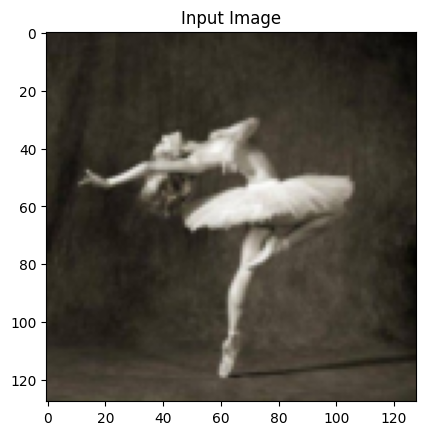

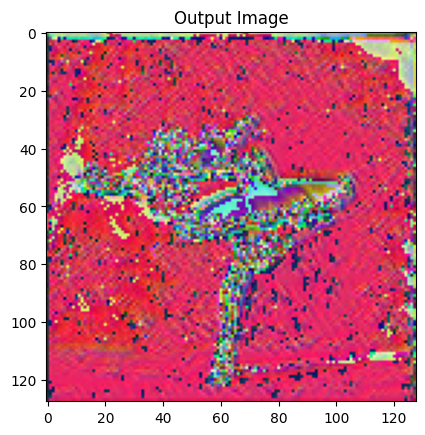

In [ ]:
class CNN4_BN(nn.Module):
    def __init__(self, style_img, content_img):
        super(CNN4_BN, self).__init__()
        self.style_img = style_img
        self.content_img = content_img
        self.normalization = Normalization(normalization_mean, normalization_std)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN3 = nn.BatchNorm2d(3)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN4 = nn.BatchNorm2d(3)
        self.relu4 = nn.ReLU()

        self.style_loss = StyleLoss(style_img)
        self.content_loss = ContentLoss(content_img)


    def forward(self, x):
        # normalize ``img``
        h = self.normalization(x)
        h = self.conv1(h)
        sloss = self.style_loss(h)
        closs = self.content_loss(h)
        h = self.BN1(h)
        h = self.relu1(h)

        h = self.conv2(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        h = self.BN2(h)
        h = self.relu2(h)

        h = self.conv3(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        h = self.BN3(h)
        h = self.relu3(h)

        h = self.conv4(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN2(h)
        return h, sloss, closs

model = CNN4_BN(style_img, content_img)
out, sloss, closs = model.forward(content_img)

print(sloss, closs)

plt.figure()
imshow(content_img, title='Input Image')

plt.figure()
imshow(out, title='Output Image')

tensor(0.0881, grad_fn=<AddBackward0>) tensor(1.5682, grad_fn=<AddBackward0>)


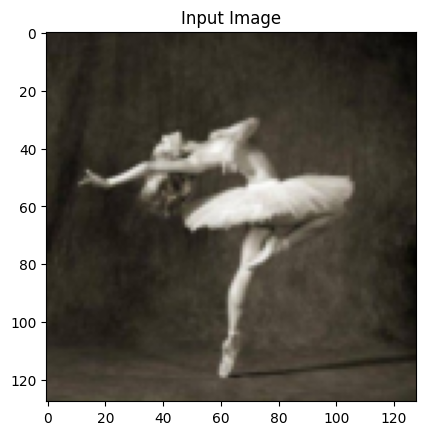

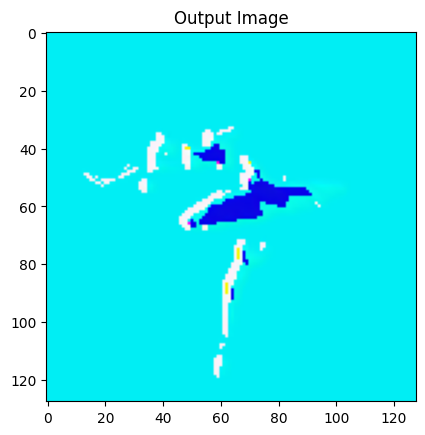

In [ ]:
class CNN5(nn.Module):
    def __init__(self, style_img, content_img):
        super(CNN5, self).__init__()
        self.style_img = style_img
        self.content_img = content_img
        self.normalization = Normalization(normalization_mean, normalization_std)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN3 = nn.BatchNorm2d(3)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN4 = nn.BatchNorm2d(3)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN5 = nn.BatchNorm2d(3)
        self.relu5 = nn.ReLU()

        self.style_loss = StyleLoss(style_img)
        self.content_loss = ContentLoss(content_img)


    def forward(self, x):
        # normalize ``img``
        h = self.normalization(x)
        h = self.conv1(h)
        sloss = self.style_loss(h)
        closs = self.content_loss(h)
        #h = self.BN1(h)
        h = self.relu1(h)

        h = self.conv2(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN1(h)
        h = self.relu2(h)

        h = self.conv3(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN1(h)
        h = self.relu3(h)

        h = self.conv4(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN1(h)
        h = self.relu4(h)

        h = self.conv5(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN2(h)
        return h, sloss, closs

model = CNN5(style_img, content_img)
out, sloss, closs = model.forward(content_img)

print(sloss, closs)

plt.figure()
imshow(content_img, title='Input Image')

plt.figure()
imshow(out, title='Output Image')

tensor(0.0089, grad_fn=<AddBackward0>) tensor(1.1577, grad_fn=<AddBackward0>)


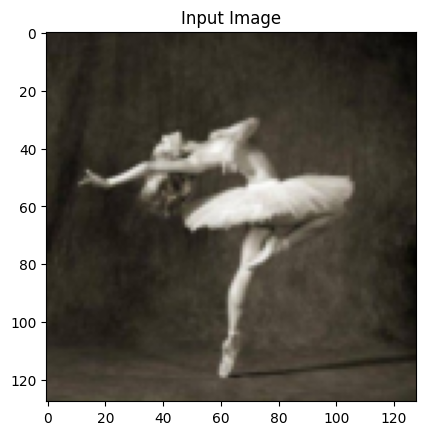

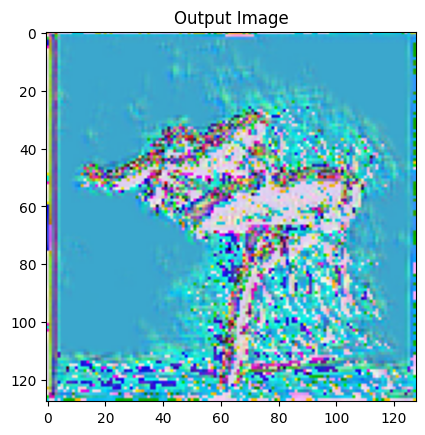

In [ ]:
class CNN5_BN(nn.Module):
    def __init__(self, style_img, content_img):
        super(CNN5_BN, self).__init__()
        self.style_img = style_img
        self.content_img = content_img
        self.normalization = Normalization(normalization_mean, normalization_std)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN3 = nn.BatchNorm2d(3)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN4 = nn.BatchNorm2d(3)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN5 = nn.BatchNorm2d(3)
        self.relu5 = nn.ReLU()

        self.style_loss = StyleLoss(style_img)
        self.content_loss = ContentLoss(content_img)


    def forward(self, x):
        # normalize ``img``
        h = self.normalization(x)
        h = self.conv1(h)
        sloss = self.style_loss(h)
        closs = self.content_loss(h)
        h = self.BN1(h)
        h = self.relu1(h)

        h = self.conv2(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        h = self.BN2(h)
        h = self.relu2(h)

        h = self.conv3(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        h = self.BN3(h)
        h = self.relu3(h)

        h = self.conv4(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        h = self.BN4(h)
        h = self.relu4(h)

        h = self.conv5(h)
        sloss += self.style_loss(h)
        closs += self.content_loss(h)
        #h = self.BN2(h)
        return h, sloss, closs

model = CNN5_BN(style_img, content_img)
out, sloss, closs = model.forward(content_img)

print(sloss, closs)

plt.figure()
imshow(content_img, title='Input Image')

plt.figure()
imshow(out, title='Output Image')

In [ ]:
def run_style_transfer(model, content_img, style_img, input_img, num_steps=300, style_weight=1000000, content_weight=1):
    model = model.to(device = device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)# complete using Adam optimizer in PyTorch

    loss_arr = []
    loss_arr2 = []

    for n in range(num_steps):
        out, sloss, closs = model.forward(input_img)

        #loss = sloss * style_weight + closs * content_weight
        #loss = sloss * style_weight
        loss = closs
        optimizer.zero_grad()
        # complete: compute the gradient of loss
        # use auto-grad (just 1 line)
        loss.backward()

        # one step of gradient descent
        optimizer.step()
        loss_arr.append(loss.item())

    for n in range(num_steps):
        out, sloss, closs = model.forward(input_img)

        loss = sloss * style_weight + closs * content_weight
        #loss = sloss * style_weight
        #loss = closs
        optimizer.zero_grad()
        # complete: compute the gradient of loss
        # use auto-grad (just 1 line)
        loss.backward()

        # one step of gradient descent
        optimizer.step()
        loss_arr2.append(loss.item())
    return model, loss_arr, loss_arr2

In [ ]:
def train_plot(model, content_img, style_img, input_img, num_steps=500):
  trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

  out, sloss, closs = trained_model.forward(content_img)

  print(sloss, closs)

  plt.figure()
  imshow(content_img, title='Input Image')

  plt.figure()
  imshow(out, title='Output Image')

  plt.figure()
  plt.plot(loss_arr)
  plt.xlabel('steps')
  plt.ylabel('content only loss')
  plt.title('content only loss')

  plt.figure()
  plt.plot(loss_arr2)
  plt.xlabel('steps')
  plt.ylabel('content and style only loss')
  plt.title('content and style loss')

  plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


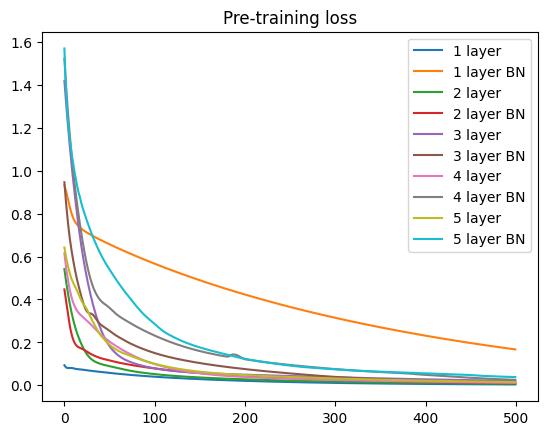

In [ ]:
model = CNN1(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.figure()
plt.plot(loss_arr, label = "1 layer")

model = CNN1_BN(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr, label = "1 layer BN")

model = CNN2(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr, label = "2 layer")

model = CNN2_BN(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr, label = "2 layer BN")

model = CNN3(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr, label = "3 layer")

model = CNN3_BN(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr, label = "3 layer BN")

model = CNN4(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr, label = "4 layer")

model = CNN4_BN(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr, label = "4 layer BN")

model = CNN5(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr, label = "5 layer")

model = CNN5_BN(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr, label = "5 layer BN")

plt.title("Pre-training loss")
plt.legend()
plt.show()

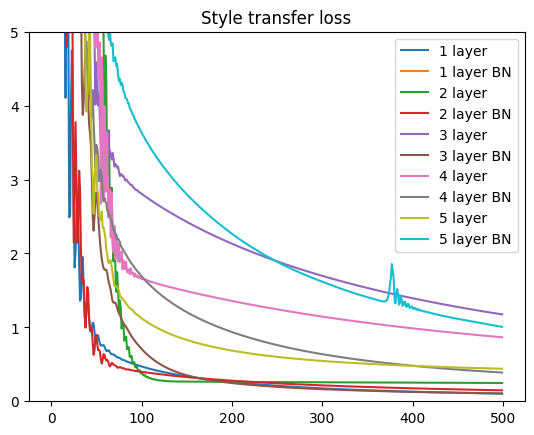

In [ ]:
model = CNN1(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.figure()
plt.plot(loss_arr2, label = "1 layer")

model = CNN1_BN(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr2, label = "1 layer BN")

model = CNN2(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr2, label = "2 layer")

model = CNN2_BN(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr2, label = "2 layer BN")

model = CNN3(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr2, label = "3 layer")

model = CNN3_BN(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr2, label = "3 layer BN")

model = CNN4(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr2, label = "4 layer")

model = CNN4_BN(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr2, label = "4 layer BN")

model = CNN5(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr2, label = "5 layer")

model = CNN5_BN(style_img, content_img)
trained_model, loss_arr, loss_arr2 = run_style_transfer(model, content_img, style_img, content_img, num_steps=500)

plt.plot(loss_arr2, label = "5 layer BN")

plt.title("Style transfer loss")
plt.legend()
plt.ylim(0, 5)
plt.show()

tensor(3.4472e-08, grad_fn=<MseLossBackward0>) tensor(0.0098, grad_fn=<MseLossBackward0>)


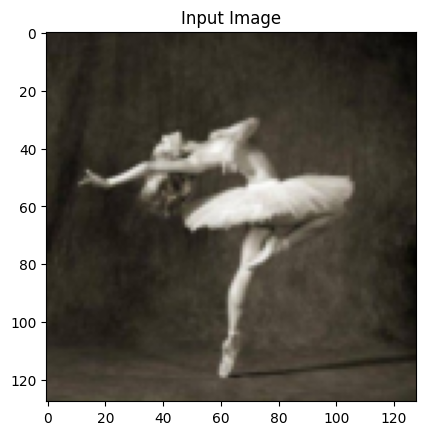

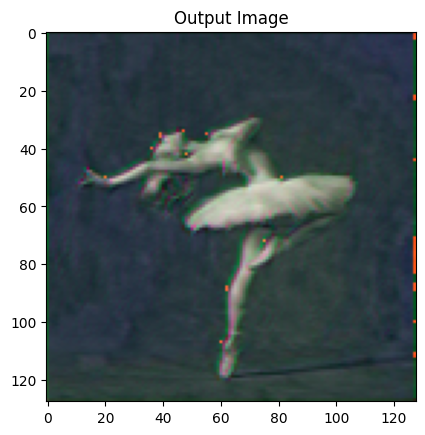

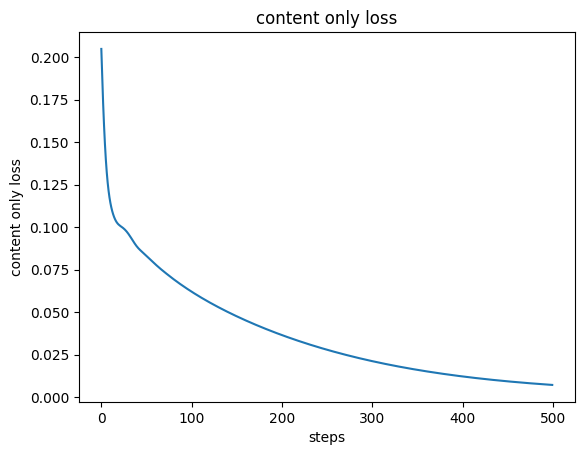

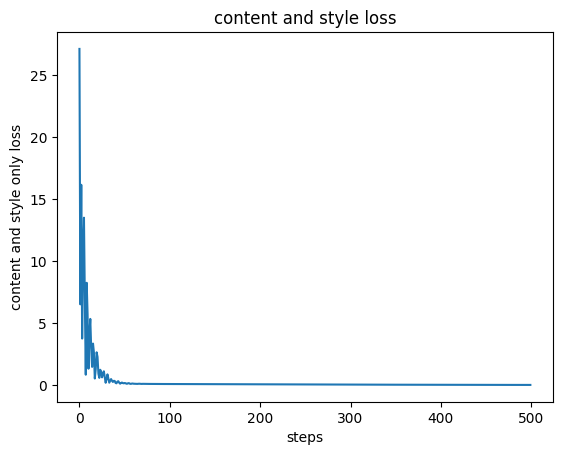

In [ ]:
model = CNN1(style_img, content_img)
train_plot(model, content_img, style_img, content_img, 500)

tensor(1.6993e-05, grad_fn=<MseLossBackward0>) tensor(0.0706, grad_fn=<MseLossBackward0>)


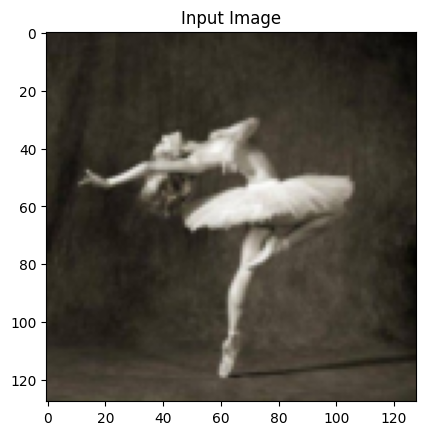

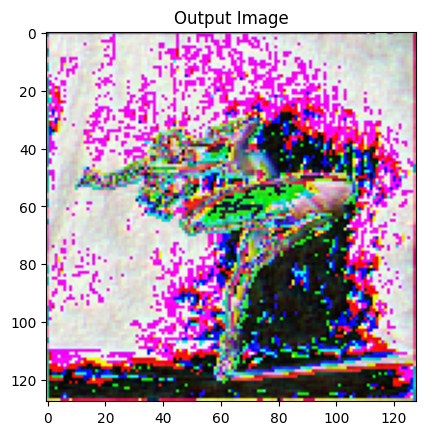

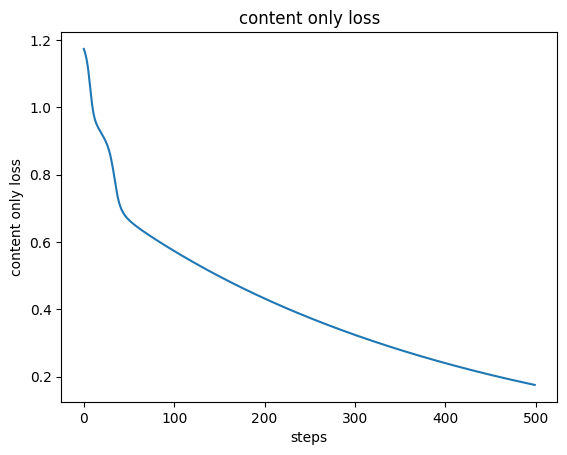

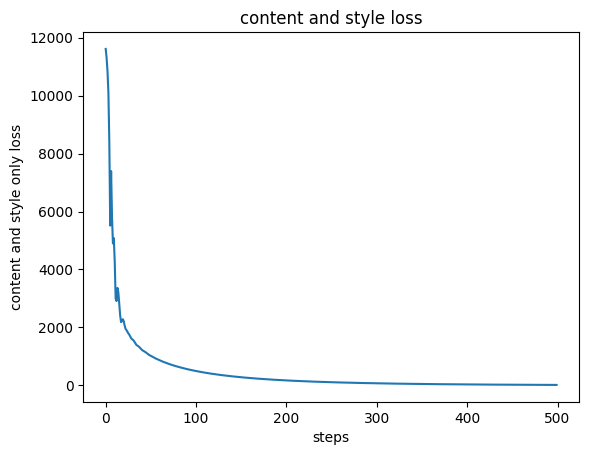

In [ ]:
model = CNN1_BN(style_img, content_img)
train_plot(model, content_img, style_img, content_img, 500)

tensor(4.2890e-07, grad_fn=<AddBackward0>) tensor(0.0721, grad_fn=<AddBackward0>)


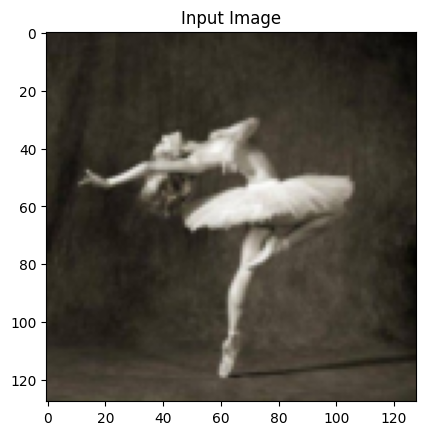

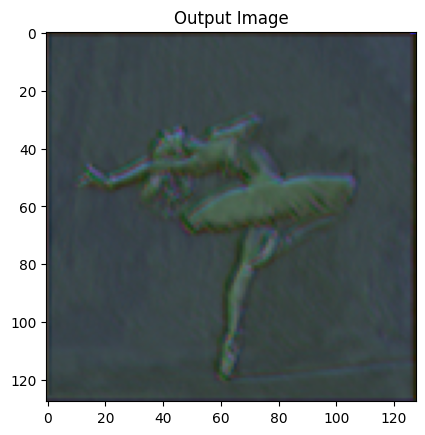

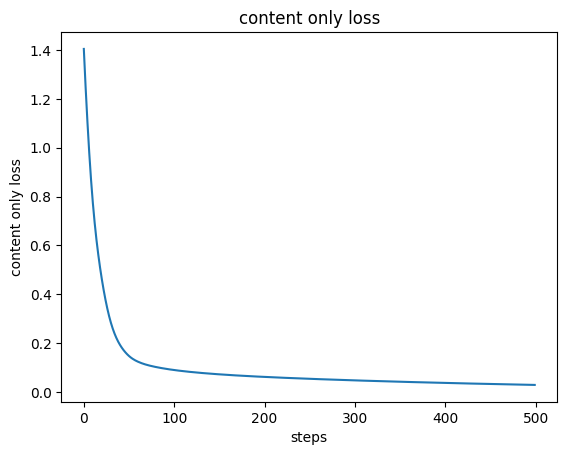

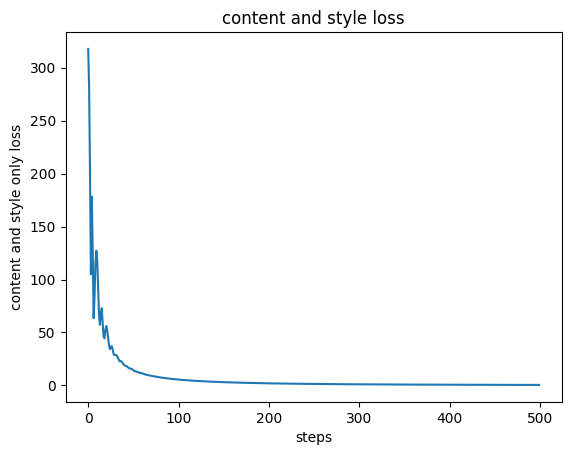

In [ ]:
model = CNN2(style_img, content_img)
train_plot(model, content_img, style_img, content_img, 500)

tensor(1.6409e-08, grad_fn=<AddBackward0>) tensor(0.0181, grad_fn=<AddBackward0>)


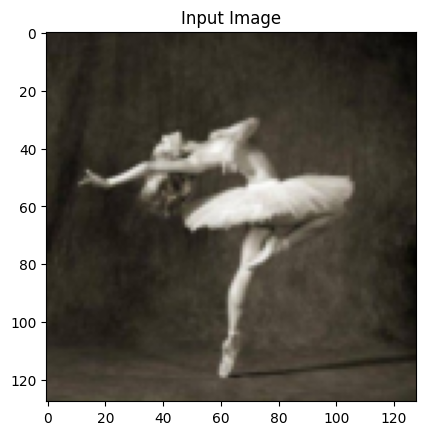

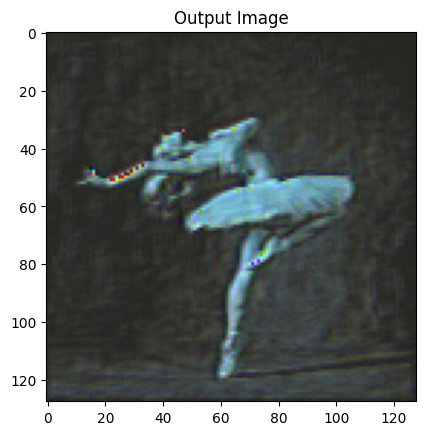

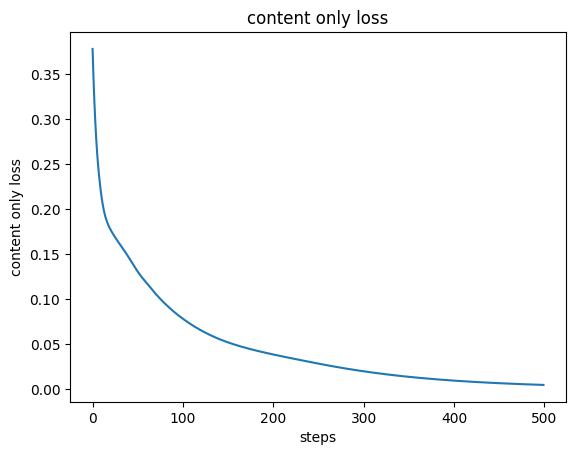

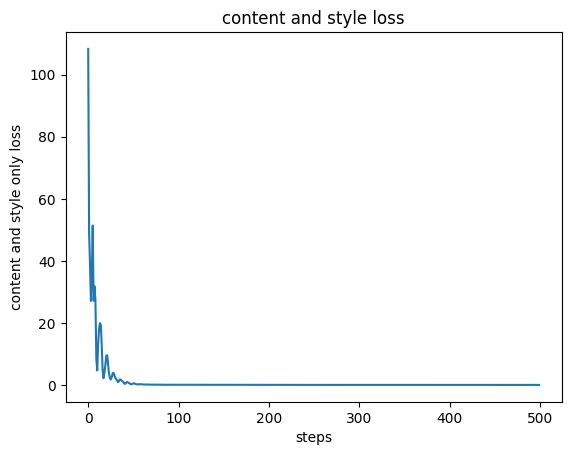

In [ ]:
model = CNN2_BN(style_img, content_img)
train_plot(model, content_img, style_img, content_img, 500)

tensor(5.5848e-07, grad_fn=<AddBackward0>) tensor(0.0466, grad_fn=<AddBackward0>)


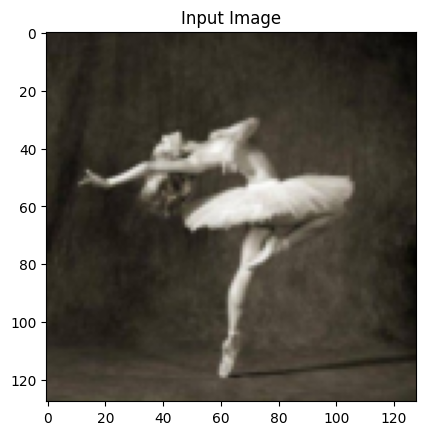

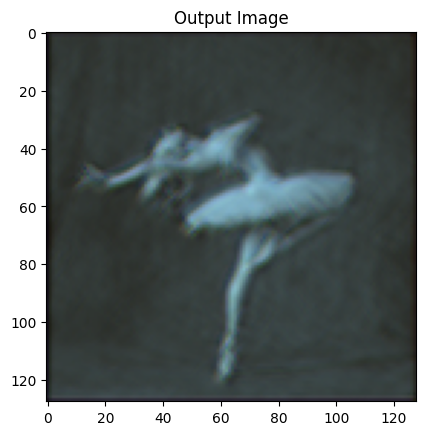

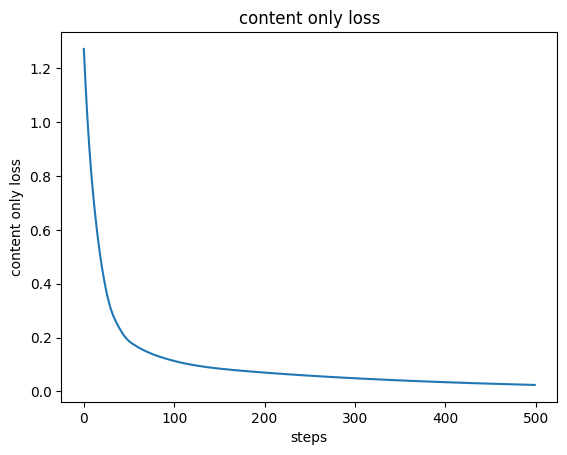

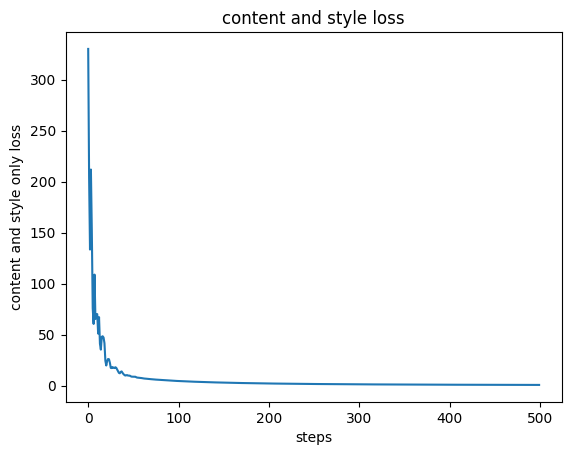

In [ ]:
model = CNN3(style_img, content_img)
train_plot(model, content_img, style_img, content_img, 500)

tensor(4.5577e-07, grad_fn=<AddBackward0>) tensor(0.0697, grad_fn=<AddBackward0>)


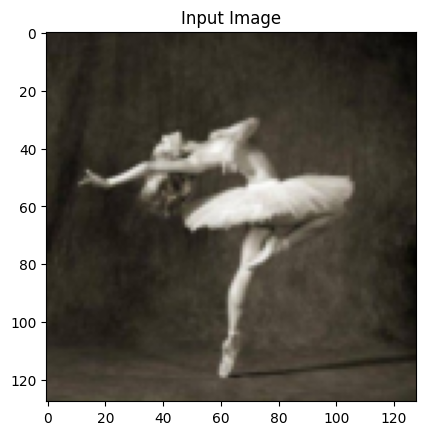

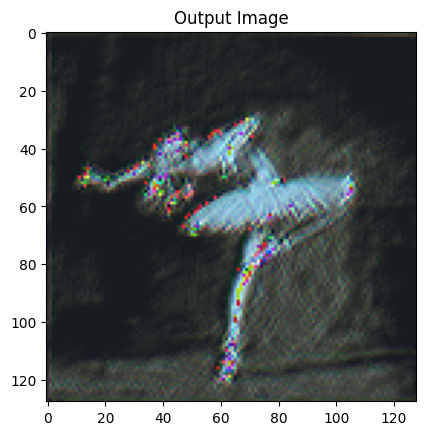

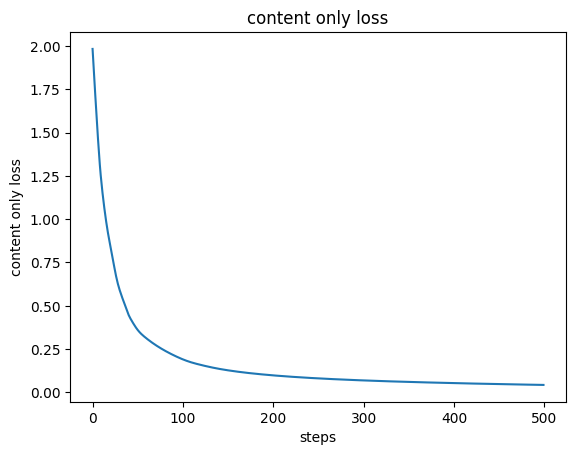

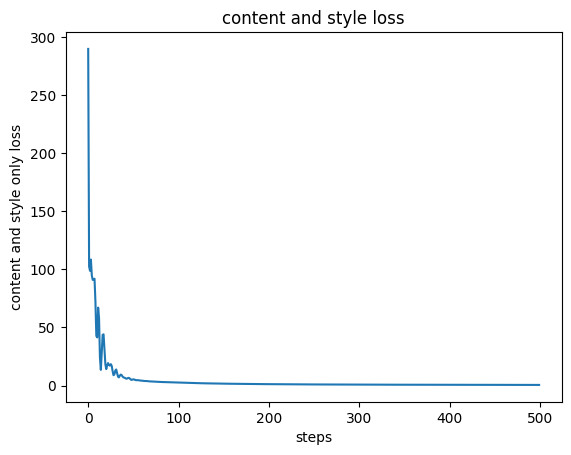

In [ ]:
model = CNN3_BN(style_img, content_img)
train_plot(model, content_img, style_img, content_img, 500)

tensor(2.9970e-07, grad_fn=<AddBackward0>) tensor(0.0418, grad_fn=<AddBackward0>)


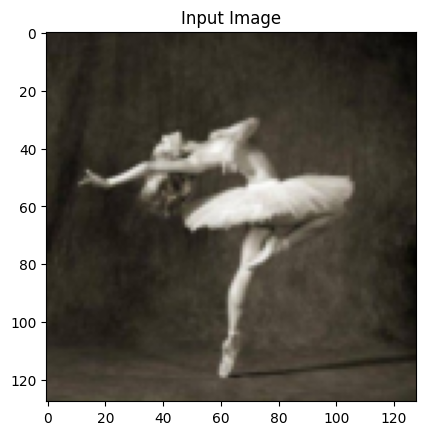

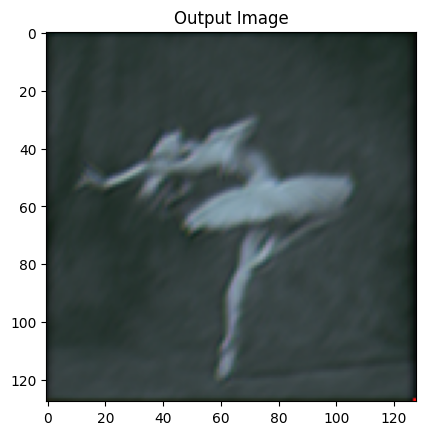

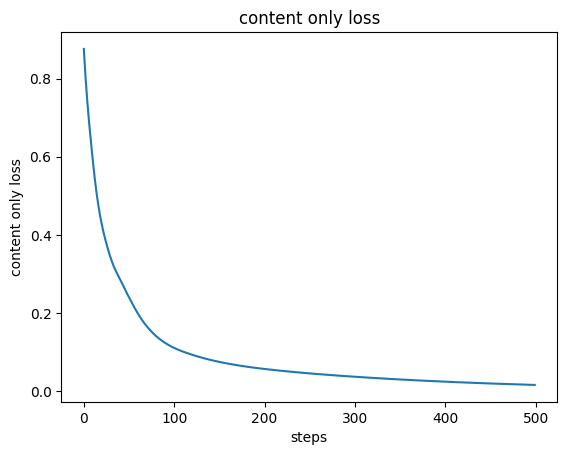

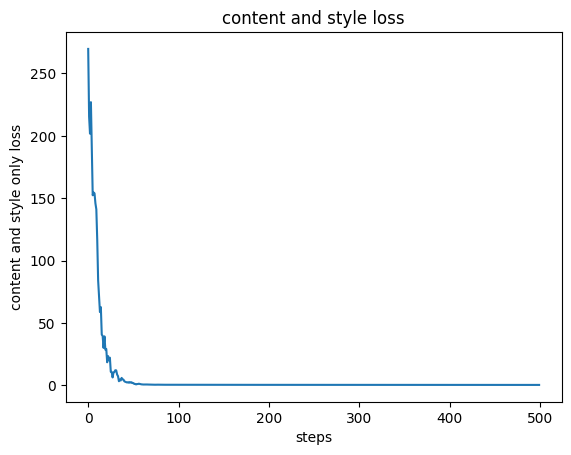

In [ ]:
model = CNN4(style_img, content_img)
train_plot(model, content_img, style_img, content_img, 500)

tensor(1.8167e-07, grad_fn=<AddBackward0>) tensor(0.0633, grad_fn=<AddBackward0>)


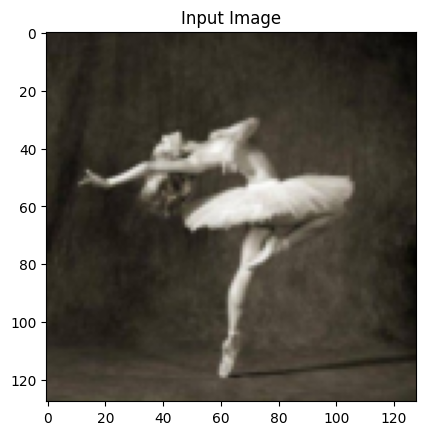

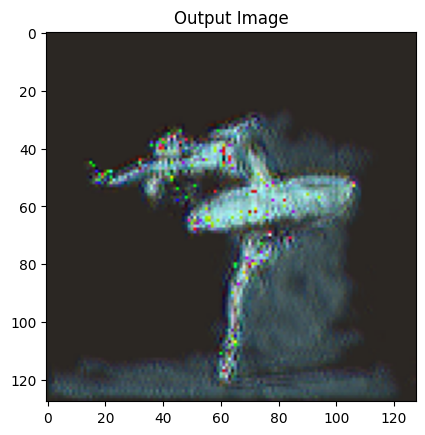

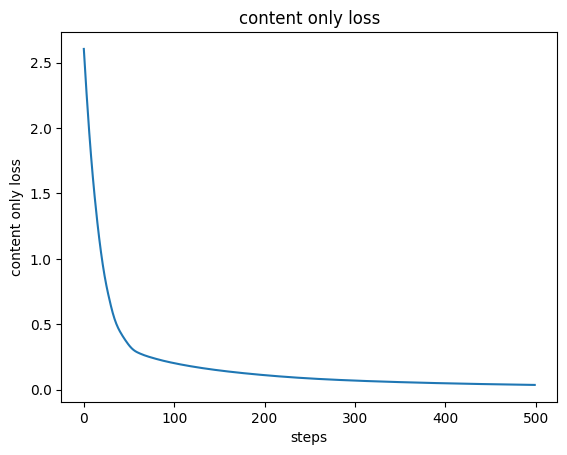

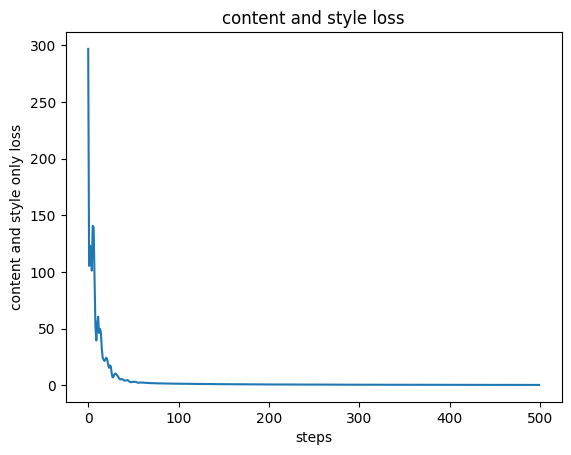

In [ ]:
model = CNN4_BN(style_img, content_img)
train_plot(model, content_img, style_img, content_img, 500)

tensor(3.7647e-07, grad_fn=<AddBackward0>) tensor(0.1436, grad_fn=<AddBackward0>)


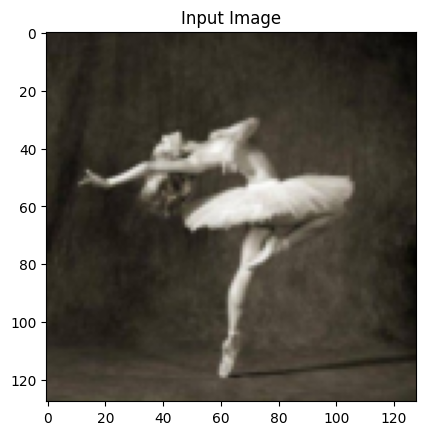

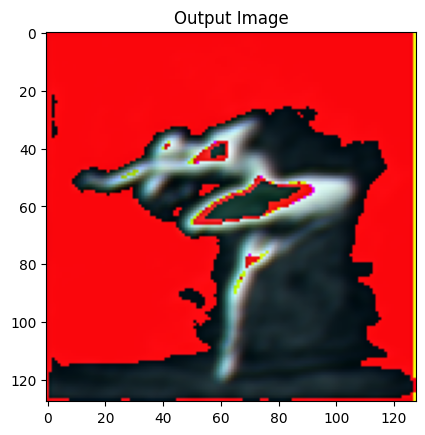

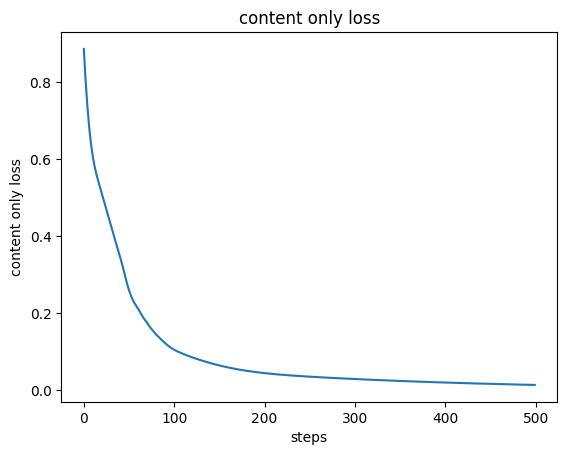

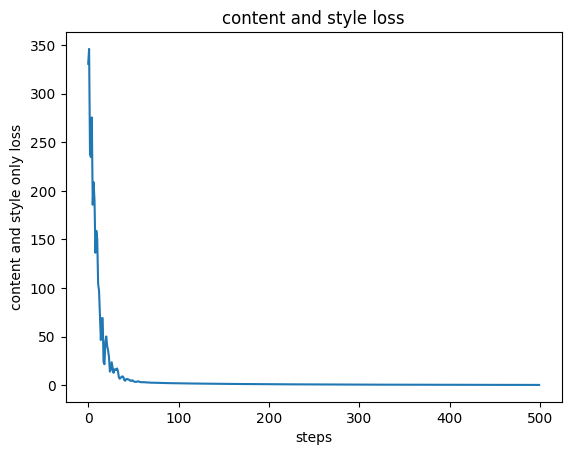

In [ ]:
model = CNN5(style_img, content_img)
train_plot(model, content_img, style_img, content_img, 500)

tensor(1.4019e-07, grad_fn=<AddBackward0>) tensor(0.2972, grad_fn=<AddBackward0>)


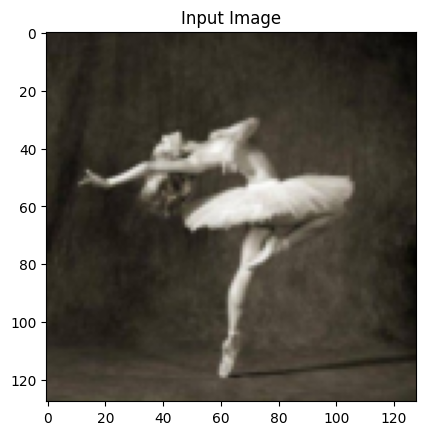

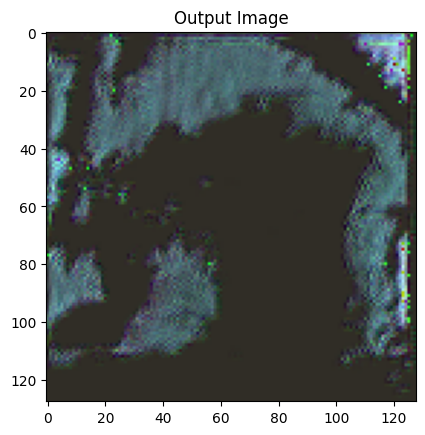

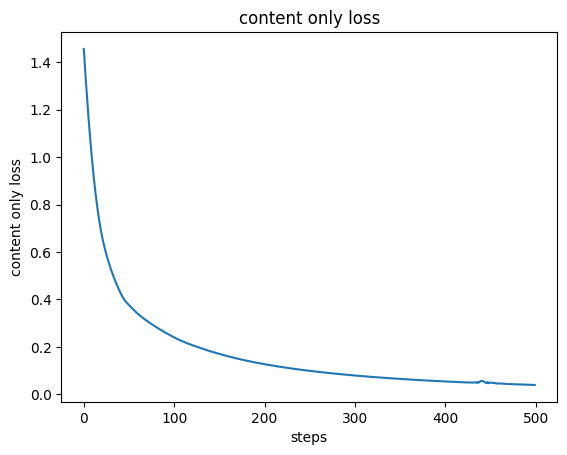

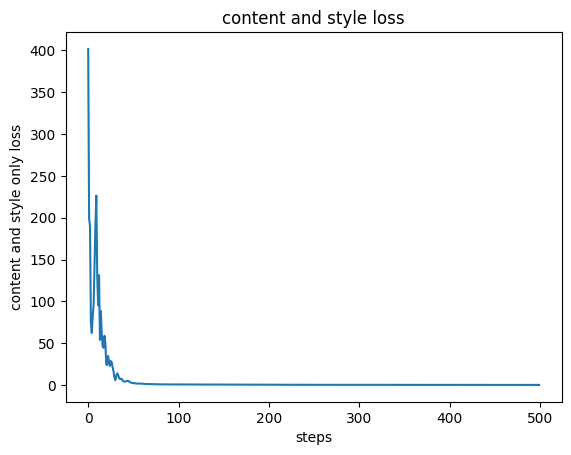

In [ ]:
model = CNN5_BN(style_img, content_img)
train_plot(model, content_img, style_img, content_img, 500)